# About the Project

The goal of this project is to build an **image classification model** for the CIFAR-10 dataset using transfer learning with ResNet50.

**CIFAR-10** is a well-known computer vision benchmark containing 60,000 32×32 color images across **10 mutually exclusive classes** (e.g., airplane, automobile, bird, cat, etc.). The dataset is split into 50,000 training images and 10,000 test images.


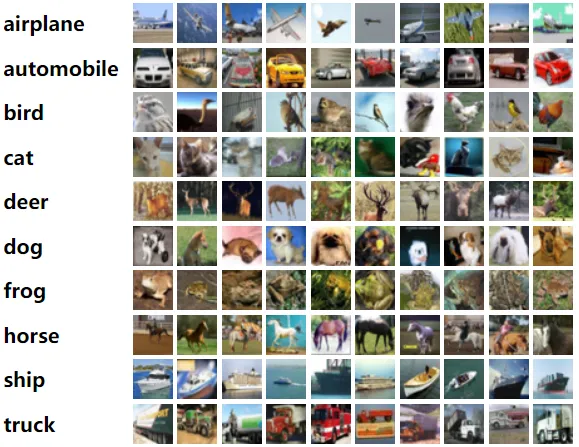

For this project, we constrain ourselves to 10,000 training samples to simulate limited-data scenarios and reduce training time. Our approach leverages a **pretrained ResNet50 model** (trained on ImageNet) as a feature extractor. We first freeze the pretrained layers and train only the custom classification head, then unfreeze the entire network for fine-tuning.

**Key steps in this project include:**

* Importing and exploring the CIFAR-10 dataset
* Preprocessing images for ResNet50
* Building a transfer learning pipeline with a frozen base model
* Training a custom classification head
* Fine-tuning the entire model
* Evaluating model performance on the test set

This project aims to demonstrate the power of transfer learning for small-scale datasets, highlight practical techniques for fine-tuning deep networks, and develop hands-on experience with modern computer vision workflows.


# Setup & Data Loading

In this section, we set up our environment by importing all necessary libraries, defining visualization settings, and loading the CIFAR-10 dataset.

We will:

- Import key libraries for data manipulation, visualization, and modeling
- Configure the color palette for plots
- Load the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 classes, with 50,000 for training and 10,000 for testing

The CIFAR-10 dataset is a standard benchmark for image classification tasks, making it an excellent choice for testing transfer learning with pre-trained convolutional neural networks.


In [1]:
!pip install tensorflow

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")

# Data handling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import regularizers

Color palette for visualizations: Set2


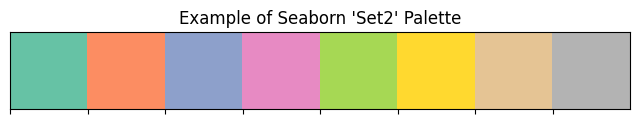

In [3]:
# Set the seaborn palette
sns.set_palette("Set2")
print("Color palette for visualizations: Set2")

# Example plot to display the palette
sns.palplot(sns.color_palette("Set2"))
plt.title("Example of Seaborn 'Set2' Palette")
plt.show()

In [4]:
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(train_images,train_labels),(test_images,test_labels) = cifar10.load_data()
print("CIFAR-10 dataset loaded")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
CIFAR-10 dataset loaded


# Exploratory Data Analysis

In this section, we'll explore the CIFAR-10 dataset to better understand its structure and content before modeling.  
We'll examine:

- **Data Overview:** Shape of images and labels
- **Pixel Statistics:** Pixel value ranges and channel means
- **Class Distribution:** Frequency of each category
- **Example Images:** Visual samples per class

Exploring the data helps ensure we understand its scale, distribution, and any preprocessing requirements for our model.

**Data Overview**

In [5]:
# Data overview
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Unique classes: {np.unique(train_labels)}")

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


**Pixels**

In [6]:
# Check pixel value ranges
print(f"Min pixel value: {np.min(train_images)}")
print(f"Max pixel value: {np.max(train_images)}")

Min pixel value: 0
Max pixel value: 255


In [7]:
# Pixel statistics
means = train_images.mean(axis=(0,1,2))  # per channel
stds = train_images.std(axis=(0,1,2))

print(f"Channel means (RGB): {means}")
print(f"Channel stds (RGB): {stds}")

Channel means (RGB): [125.30691805 122.95039414 113.86538318]
Channel stds (RGB): [62.99321928 62.08870764 66.70489964]


**Class Distribution**

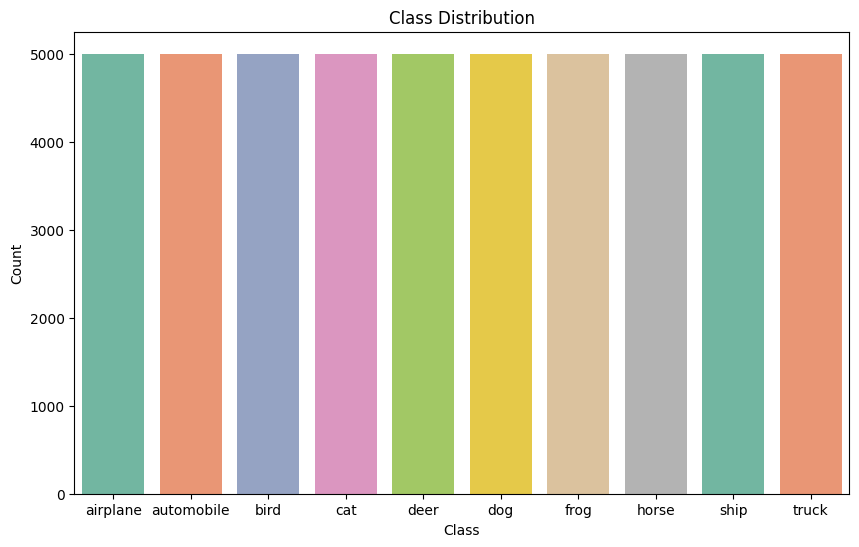

In [8]:
# Classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Class distribution
labels_flat = train_labels.flatten()
label_counts = pd.Series(labels_flat).value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=label_counts, palette="Set2", hue=class_names)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**Sample Image per Class**

Sample Images CIFAR-10


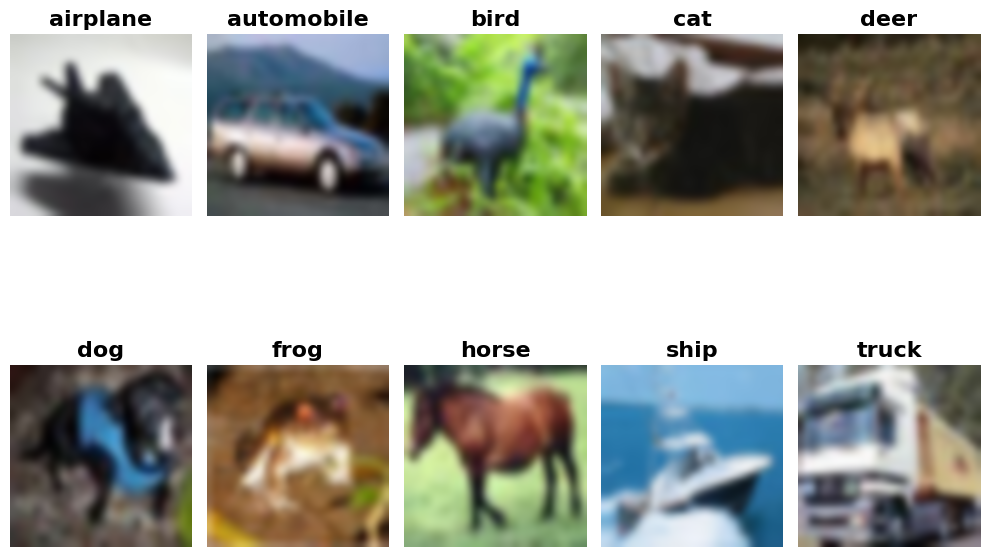

In [9]:
# Visualize sample images per class
print("Sample Images CIFAR-10")
plt.figure(figsize=(10,8))
for i in range(10):
    idx = np.where(train_labels == i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(train_images[idx], interpolation='bicubic')
    plt.title(class_names[i], fontsize=16, fontweight='bold')
    plt.axis('off')
plt.tight_layout()
plt.show()

**15 Random Image Samples**

15 Random Images CIFAR-10


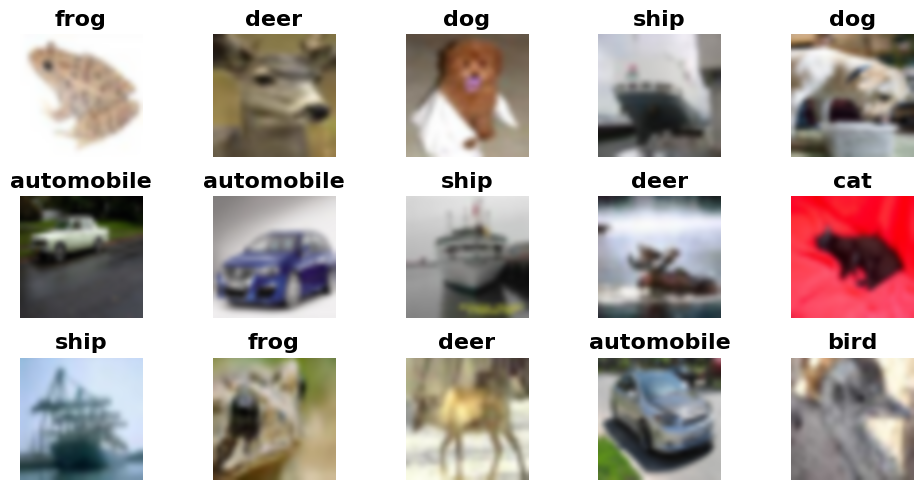

In [10]:
# Random samples
print("15 Random Images CIFAR-10")

num_samples = 15
plt.figure(figsize=(10,5))
for i in range(num_samples):
    idx = np.random.randint(0, len(train_images))
    if train_labels.ndim == 2 and train_labels.shape[1] > 1:
        label_idx = np.argmax(train_labels[idx])
    else:
        label_idx = train_labels[idx].item()
    plt.subplot(3,5,i+1)
    plt.imshow(train_images[idx], interpolation='bicubic')
    plt.title(class_names[label_idx], fontsize=16, fontweight='bold')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Preprocessing

Before we can train the model, we need to prepare the data by performing several preprocessing steps:

1.	**Subset the training data**
  * We limit the training set to 10,000 images.
  * We reserve 2,000 images (randomly shuffled) as our validation set.
  * The remaining 8,000 images will be used for training.
2.	**One-Hot Encode Labels**
  * Converts categorical class labels into one-hot encoded vectors for training, validation, and test sets.
3.	**Normalize Images**
  * We apply preprocess_input from ResNet50 to scale pixel values appropriately.
4.	**Data Augmentation**
  * 	We configure an ImageDataGenerator to perform random transformations including:
  * Rotation
  * Shifts
  * Zoom
  * Horizontal flips
  * Brightness adjustments

These steps help improve model performance by reducing overfitting and improving generalization.


**Limit train data and split into train and validation set**

In [11]:
# Limit the data
n = 12000

train_images = train_images[:n]
train_labels = train_labels[:n]

# Shuffle train data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Validation set
validation_images = train_images[:2000]
validation_labels = train_labels[:2000]

# Train set
train_images = train_images[2000:]
train_labels = train_labels[2000:]

print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {validation_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (10000, 32, 32, 3)
Validation images shape: (2000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)


**Encode Labels**

In [12]:
# One-hot encode labels
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

print("Labels are successfully encoded.")

Labels are successfully encoded.


**Normalize Images**

In [13]:
# Normalize images
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)
validation_images = preprocess_input(validation_images)

print("Images have been successfully normalized.")

Images have been successfully normalized.


**Data Augmentation**

In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

print("Data Preprocessing Complete!")

Data Preprocessing Complete!


# Transfer Learning with ResNet50


We build and train a transfer learning model using **ResNet50** as the base.

1. **Building the Custom Head**
  * We load ResNet50 pretrained on ImageNet with include_top=False so we can add our own classification layers.
  * We design a custom fully connected head:
  * Global Average Pooling
  * Several Dense layers with `ReLU` activations
  * Batch Normalization for better convergence
  * Dropout for regularization
  * The final output is a `Softmax` layer for our 10 CIFAR-10 classes.
  * We freeze all ResNet50 base layers so only the custom head trains initially.


2. **Phase 1: Training the Head**
  * We compile the model with `AdamW` optimizer, a weight decay regularizer, and label smoothing (0.1) to improve calibration.
  * We train only the custom head, keeping the ResNet50 base frozen.
  * Early stopping and `ReduceLROnPlateau` are used to prevent overfitting and adjust learning rate.

3. **Phase 2: Progressive Fine-Tuning**
  * We gradually unfreeze the last layers of ResNet50 in 4 phases:
  * `Step 1`: Unfreeze top 5 layers
  * `Step 2`: Unfreeze top 10 layers
  * `Step 3`: Unfreeze top 15 layers
  * `Step 4`: Unfreeze top 20 layers
  * In each Step:
    * Layers below the selected threshold remain frozen to preserve learned features.
    * A CosineDecay learning rate schedule with low initial LR ensures stable fine-tuning.
    * We recompile and retrain the model in each step.
  * Early stopping and LR reduction callbacks are used in all phases to avoid overfitting.


This strategy allows us to leverage pretrained ImageNet features while adapting deeper layers of ResNet50 to our CIFAR-10 dataset, progressively improving validation accuracy.


# 10-Epochs Model (main requirement)

This run fulfills the school requirement of max 10 epochs.

> For my live presentation I trained for 30 epochs (by mistake exceeding the requirement). To comply with the requirement, here I present the model re-trained for 10 epochs.



In [16]:
print("Building ResNet50 base with custom head")

# ResNet50 pre-trained (ImageNet), without the top classification layer, adjusted input shape (32x32)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Define L2 regularization strength
l2_reg = regularizers.l2(0.001)

# Add custom classification head on top of frozen base
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First dense layer with L2 regularization
x = Dense(512, activation='relu', kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Second dense layer with L2 regularization
x = Dense(256, activation='relu', kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Third dense layer with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2_reg)(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer for CIFAR-10 classes with softmax activation
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2_reg)(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained ResNet50 base during initial training
for layer in base_model.layers:
    layer.trainable = False

print("\nModel built succesfully!")
print("\nPhase 1: Training Head Only")

# Compile the model with AdamW optimizer, label smoothing, and L2 weight decay
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Train only the new head layers
history_head = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=10,
    validation_data=(validation_images, validation_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ],
    verbose=1
)

print("\nNew head has been succesfully trained!")
print(f"\nBest val acc: {max(history_head.history['val_accuracy']):.4f}")

# LEARNING RATE SCHEDULE
def get_cosine_decay_lr(initial_lr):
    """
    Returns a cosine decay schedule for fine-tuning.
    Helps reduce LR smoothly over time.
    """
    return CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        alpha=1e-6
    )

print("\nPhase 2: Fine-Tuning")

all_finetune_histories = []

# Progressively unfreeze more layers and use smaller learning rates
fine_tuning_plan = [
    {"layers": 5, "lr": 3e-5},
    {"layers": 10, "lr": 2e-5},
    {"layers": 15, "lr": 1e-5},
    {"layers": 20, "lr": 5e-6},
]

# Run fine-tuning in stages
for phase, config in enumerate(fine_tuning_plan, 1):
    print(f"\nStep {phase}/4: Unfreezing top {config['layers']} layers at LR={config['lr']}")

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze top N layers
    for layer in base_model.layers[-config['layers']:]:
        layer.trainable = True

    # Use cosine learning rate schedule
    lr_schedule = get_cosine_decay_lr(config['lr'])
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

    # Re-compile with new optimizer and LR schedule
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    # Train the model further with partial unfreezing
    history = model.fit(
        datagen.flow(train_images, train_labels, batch_size=32),
        epochs=10,
        validation_data=(validation_images, validation_labels),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        ],
        verbose=1
    )

    # Save history for analysis
    all_finetune_histories.append(history)
    print(f"Step {phase} best val acc: {max(history.history['val_accuracy']):.4f}")

Building ResNet50 base with custom head

Model built succesfully!

Phase 1: Training Head Only
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.2584 - loss: 3.8974 - val_accuracy: 0.5430 - val_loss: 2.7834 - learning_rate: 0.0010
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.4268 - loss: 3.0658 - val_accuracy: 0.5910 - val_loss: 2.5389 - learning_rate: 0.0010
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.4846 - loss: 2.7262 - val_accuracy: 0.6085 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.5160 - loss: 2.4990 - val_accuracy: 0.6195 - val_loss: 2.1664 - learning_rate: 0.0010
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.5327 - loss: 2.3416 - val_accuracy: 0.6320 - val_loss: 2.0443 - learning_rate: 0.0010
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.5428 - loss: 2.2106 - val_accuracy: 0.6250 - val_loss: 1.9539

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 45,101,343 (172.05 MB)

 Trainable params: 10,147,722 (38.71 MB)

 Non-trainable params: 14,658,176 (55.92 MB)

 Optimizer params: 20,295,445 (77.42 MB)

## Evaluation Functions

In [18]:
# Visualization Function
configured_lrs = [config['lr'] for config in fine_tuning_plan]

def plot_training_history(histories, phase_names, configured_lrs):
    sns.set_palette("Set2")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    for hist, name in zip(histories, phase_names):
        ax1.plot(hist.history['accuracy'], label=f'{name} - Train')
        ax1.plot(hist.history['val_accuracy'], label=f'{name} - Val')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    for hist, name in zip(histories, phase_names):
        ax2.plot(hist.history['loss'], label=f'{name} - Train')
        ax2.plot(hist.history['val_loss'], label=f'{name} - Val')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Learning Rate
    ax3.bar(phase_names, configured_lrs)
    ax3.set_title('Configured Learning Rate by Phase')
    ax3.set_xlabel('Phase')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    for i, (v, layers) in enumerate(zip(configured_lrs, [5, 10, 15, 20])):
        ax3.text(i, v * 1.05, f'LR={v:.1e}\nLayers={layers}', ha='center', va='bottom', fontsize=10)
    ax3.set_ylim(ax3.get_ylim()[0], ax3.get_ylim()[1] * 1.2)

    # Best Validation Accuracy
    val_accs = [max(hist.history['val_accuracy']) for hist in histories]
    ax4.bar(phase_names, val_accs)
    ax4.set_title('Best Validation Accuracy by Phase')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim(0, 1)
    for i, v in enumerate(val_accs):
        ax4.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

In [19]:
def evaluate_model(model, test_images, test_labels):
  # Evaluation best performing model
  best_model_idx = np.argmax([max(hist.history['val_accuracy']) for hist in all_finetune_histories])
  best_model = all_finetune_histories[best_model_idx]

  # Evaluation on test data
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print(f"Test accuracy: {test_acc:.4f}")

  # Print train accuracy
  train_acc = max(best_model.history['accuracy'])
  print(f"Train accuracy: {train_acc:.4f}")

In [20]:
def plot_confusion_matrix(model, test_images, test_labels):
  # Confusion Matrix
  y_true = np.argmax(test_labels, axis=1)
  y_pred = np.argmax(model.predict(test_images), axis=1)

  conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  plt.figure(figsize=(10,8))
  sns.heatmap(conf_matrix, annot=True, fmt=".0%", cmap='Blues',
              xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix (Counts)')
  plt.xlabel('Predicted')
  plt.ylabel('True')

## Evaluation

In this section, we evaluate the performance of our trained ResNet50-based classifier on CIFAR-10. We look at training curves, learning rate configuration, and final accuracy metrics.

**Training Metrics by Phase**

We trained the model in multiple phases, progressively unfreezing deeper layers and lowering the learning rate. Below, you can see the learning curves (accuracy and loss) for each phase of fine-tuning:

* Accuracy curves show how well the model learned on training and validation data.
* Loss curves help us see if the model overfits or diverges.
* Configured Learning Rates show the planned learning rates and number of layers unfrozen per phase.
* Best Validation Accuracy bar chart summarizes the best achieved accuracy per phase.

This visualization helps us diagnose training behaviour and assess the effectiveness of the progressive fine-tuning strategy.

**Results Summary**
* Best Validation Accuracy achieved: ~65%
* Final Test Set Accuracy: ~63%
* Final Train Set Accuracy: ~60%

Classification Report (Test Set):

* Overall Test Accuracy: ~63.7%
* Macro AVG  ~0.64


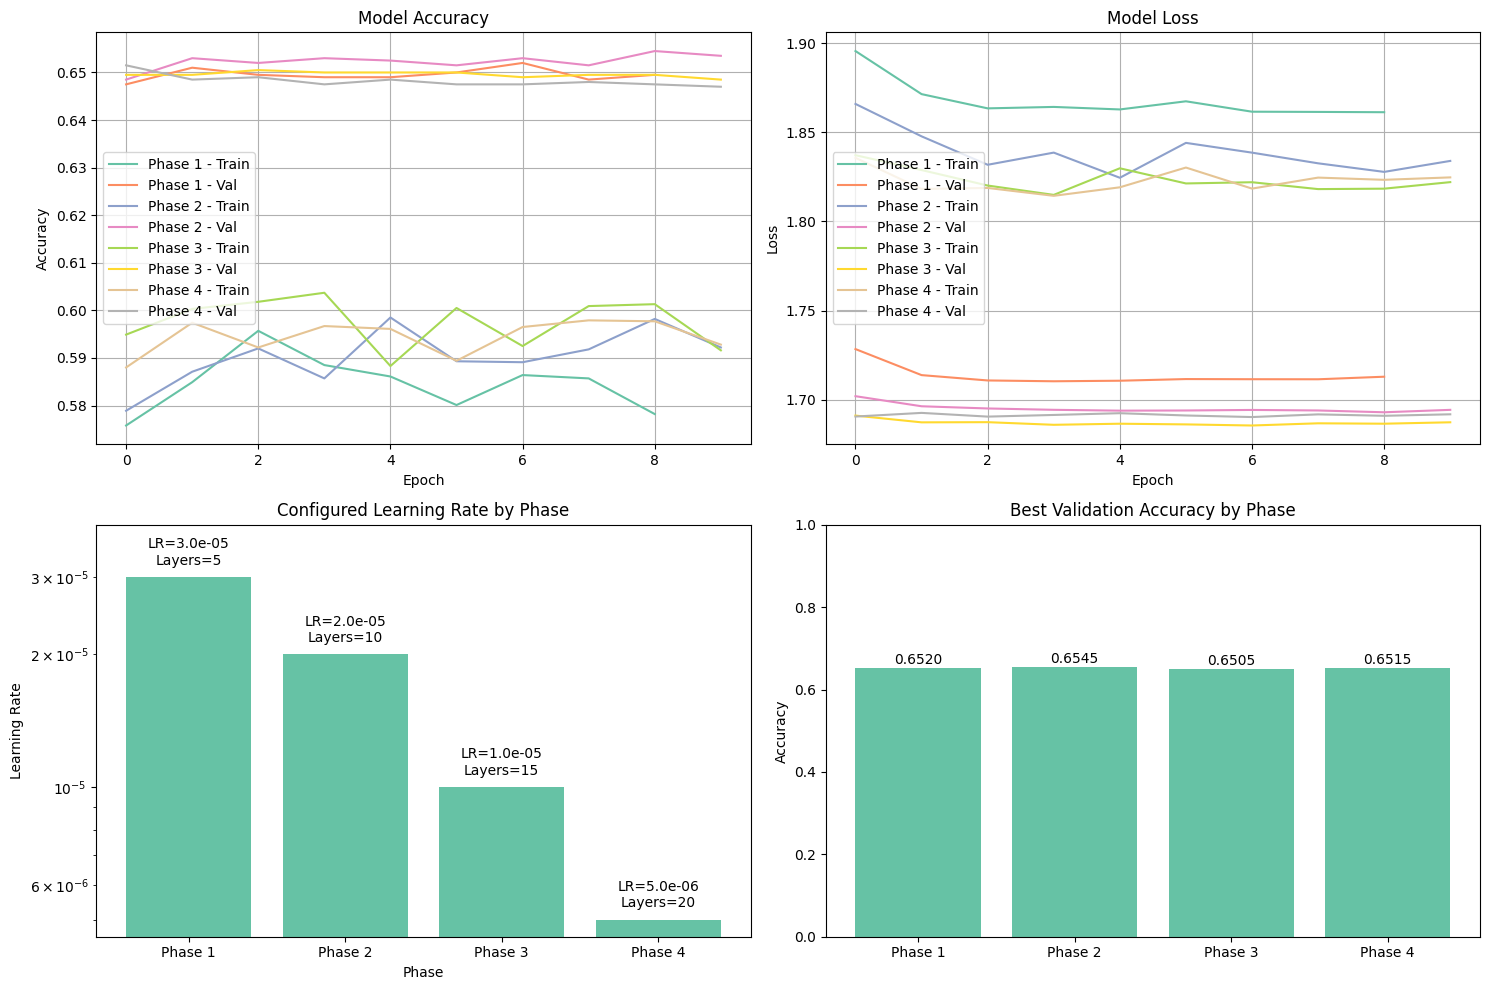

In [21]:
# Plot all training phases
plot_training_history(all_finetune_histories, ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'], configured_lrs)

In [24]:
# Classification Report
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_images), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step
              precision    recall  f1-score   support

    airplane       0.66      0.69      0.67      1000
  automobile       0.65      0.71      0.68      1000
        bird       0.63      0.51      0.56      1000
         cat       0.55      0.44      0.49      1000
        deer       0.61      0.53      0.57      1000
         dog       0.65      0.56      0.60      1000
        frog       0.60      0.81      0.69      1000
       horse       0.65      0.68      0.66      1000
        ship       0.71      0.75      0.73      1000
       truck       0.67      0.69      0.68      1000

    accuracy                           0.64     10000
   macro avg       0.64      0.64      0.63     10000
weighted avg       0.64      0.64      0.63     10000



In [22]:
evaluate_model(model, test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.6384 - loss: 1.7171
Test accuracy: 0.6371
Train accuracy: 0.5985


**Confusion Matrix**

Below is the normalized confusion matrix for predictions on the test set (10,000 images).

* Diagonal cells indicate correct predictions (higher % = better).
* Off-diagonal cells reveal confusion between classes.

This matrix helps identify which categories the model handles well (e.g. ship, frog, truck) and which are more challenging (e.g. cat, dog, bird).

**Observations**
* The model achieves solid generalization despite limited training data.

* Progressive layer unfreezing improves accuracy moderately, but requires careful learning-rate tuning to avoid overfitting.

* Certain classes (e.g. cat, dog, bird) remain challenging due to visual similarity and small object size in CIFAR-10.

* Further improvement could come from:
  * Larger training set
  * Stronger data augmentation
  * Advanced regularization techniques
  * Alternative architectures (EfficientNet, ViT)

This performance aligns with expectations for transfer learning on CIFAR-10 given ~10,000 training images and data augmentation.

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step


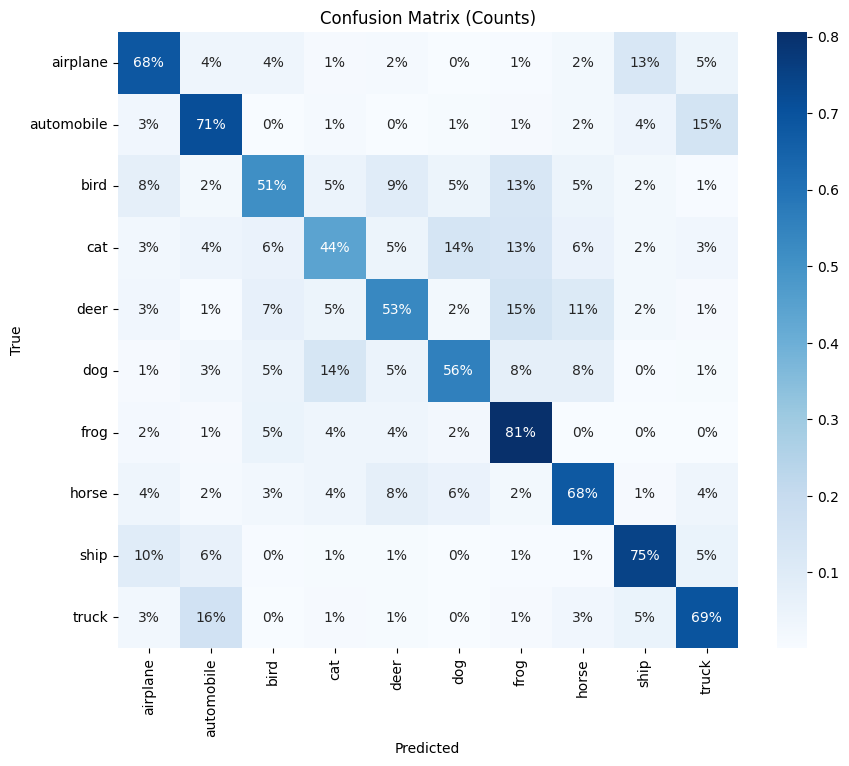

In [23]:
plot_confusion_matrix(model, test_images, test_labels)

# 30-Epochs Model


During the presentation I mistakenly trained for 30 epochs instead of the required 10, resulting in higher accuracy. For this submission I have retrained for 10 epochs as required. The performance is lower (Test Accuracy 63.7%), reflecting the shorter training time. I include the 30-epoch result here for transparency and to show the trade-off between training time and performance.



> Model from [streamlit demo](https://image-aiclassifier.streamlit.app/)




In [25]:
print("Building ResNet50 base with custom head")

# ResNet50 pre-trained (ImageNet), without the top classification layer, adjusted input shape (32x32)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


# Add custom classification head on top of frozen base
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First dense layer with L2 regularization
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Second dense layer with L2 regularization
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Third dense layer with L2 regularization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output layer for CIFAR-10 classes with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained ResNet50 base during initial training
for layer in base_model.layers:
    layer.trainable = False

print("\nModel built succesfully!")
print("\nPhase 1: Training Head Only")

# Compile the model with AdamW optimizer, label smoothing, and L2 weight decay
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Train only the new head layers
history_head = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=30,
    validation_data=(validation_images, validation_labels),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ],
    verbose=1
)

print("\nNew head has been succesfully trained!")
print(f"\nBest val acc: {max(history_head.history['val_accuracy']):.4f}")

# LEARNING RATE SCHEDULE
def get_cosine_decay_lr(initial_lr):
    """
    Returns a cosine decay schedule for fine-tuning.
    Helps reduce LR smoothly over time.
    """
    return CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        alpha=1e-6
    )

print("\nPhase 2: Fine-Tuning")

all_finetune_histories = []

# Progressively unfreeze more layers and use smaller learning rates
fine_tuning_plan = [
    {"layers": 5, "lr": 3e-5},
    {"layers": 10, "lr": 2e-5},
    {"layers": 15, "lr": 1e-5},
    {"layers": 20, "lr": 5e-6},
]

# Run fine-tuning in stages
for phase, config in enumerate(fine_tuning_plan, 1):
    print(f"\nStep {phase}/4: Unfreezing top {config['layers']} layers at LR={config['lr']}")

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze top N layers
    for layer in base_model.layers[-config['layers']:]:
        layer.trainable = True

    # Use cosine learning rate schedule
    lr_schedule = get_cosine_decay_lr(config['lr'])
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-4)

    # Re-compile with new optimizer and LR schedule
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    # Train the model further with partial unfreezing
    history = model.fit(
        datagen.flow(train_images, train_labels, batch_size=32),
        epochs=30,
        validation_data=(validation_images, validation_labels),
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        ],
        verbose=1
    )

    # Save history for analysis
    all_finetune_histories.append(history)
    print(f"Step {phase} best val acc: {max(history.history['val_accuracy']):.4f}")

Building ResNet50 base with custom head

Model built succesfully!

Phase 1: Training Head Only
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 128ms/step - accuracy: 0.2502 - loss: 2.5882 - val_accuracy: 0.5370 - val_loss: 1.5648 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.4178 - loss: 1.8425 - val_accuracy: 0.6010 - val_loss: 1.4057 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.4712 - loss: 1.6642 - val_accuracy: 0.6005 - val_loss: 1.3869 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.4974 - loss: 1.5955 - val_accuracy: 0.6295 - val_loss: 1.3534 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.5428 - loss: 1.5397 - val_accuracy: 0.6385 - val_loss: 1.3203 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.5355 - loss: 1.5381 - val_accuracy: 0.6535 - val_loss: 1.3040

## Evaluation

**Training Metrics by Phase**

We trained the model in multiple phases, progressively unfreezing deeper layers and lowering the learning rate. Below, you can see the learning curves (accuracy and loss) for each phase of fine-tuning:

* Accuracy curves show how well the model learned on training and validation data.
* Loss curves help us see if the model overfits or diverges.
* Configured Learning Rates show the planned learning rates and number of layers unfrozen per phase.
* Best Validation Accuracy bar chart summarizes the best achieved accuracy per phase.

These visualizations help us evaluate our fine-tuning strategy and adjust hyperparameters systematically.

**Results Summary**
* Best Validation Accuracy achieved: ~68%
* Final Test Set Accuracy: ~65%
* Train Set Accuracy: ~67%

* Classification Report (Test Set):

  * Overall Test Accuracy: ~65%
  * Macro Average F1-score: ~0.64

This performance is consistent with expectations for transfer learning on CIFAR-10 with a subset of only ~10,000 training images and data augmentation.



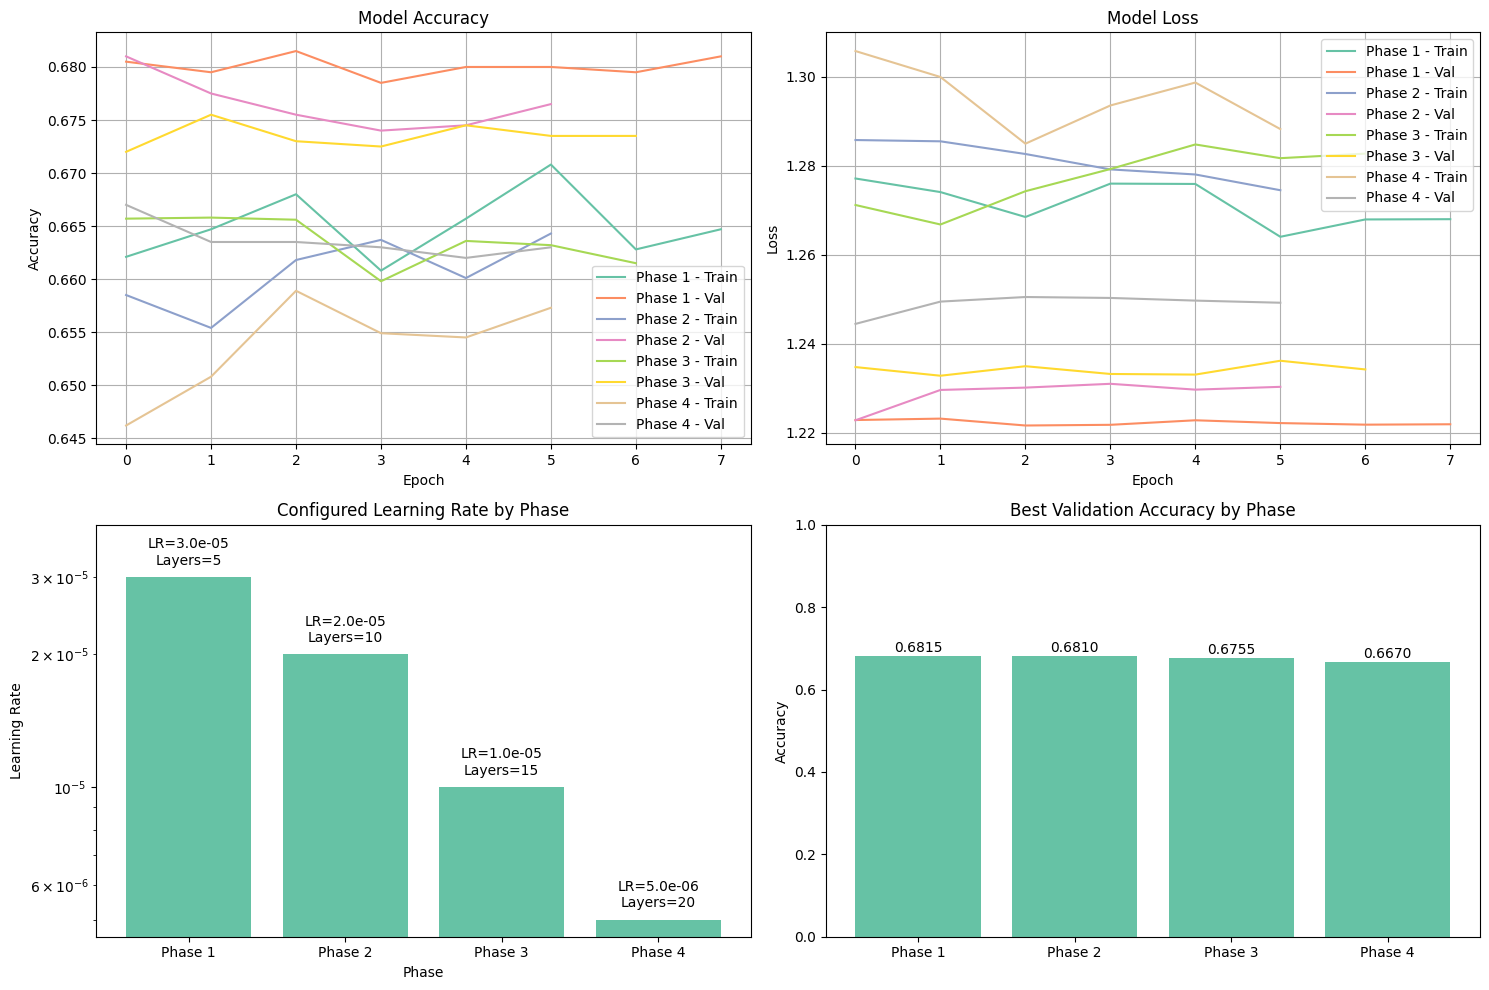

In [26]:
# Plot all training phases
plot_training_history(all_finetune_histories, ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'], configured_lrs)

In [27]:
evaluate_model(model, test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.6476 - loss: 1.3017
Test accuracy: 0.6482
Train accuracy: 0.6708


**Confusion Matrix**

Below is the normalized confusion matrix for predictions on the test set (10,000 images).

* Diagonal cells indicate correct predictions (higher % = better).
* Off-diagonal cells reveal confusion between classes.

This visualization helps us understand which classes the model distinguishes well (e.g. ship, frog, truck) and which are harder (e.g. cat, dog, bird).

**Observations**
* The model demonstrates solid generalization despite limited resolution and training data.

* Progressive fine-tuning with a learning-rate schedule achieved consistent ~65% test accuracy.

* Class-wise analysis reveals consistent challenges with visually similar categories (e.g. cat, dog, bird).

Further improvement could come from:

  * Larger training set
  * Stronger augmentation
  * Advanced regularization (label smoothing, dropout
  * Alternative architectures (EfficientNet, ViT)



313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step


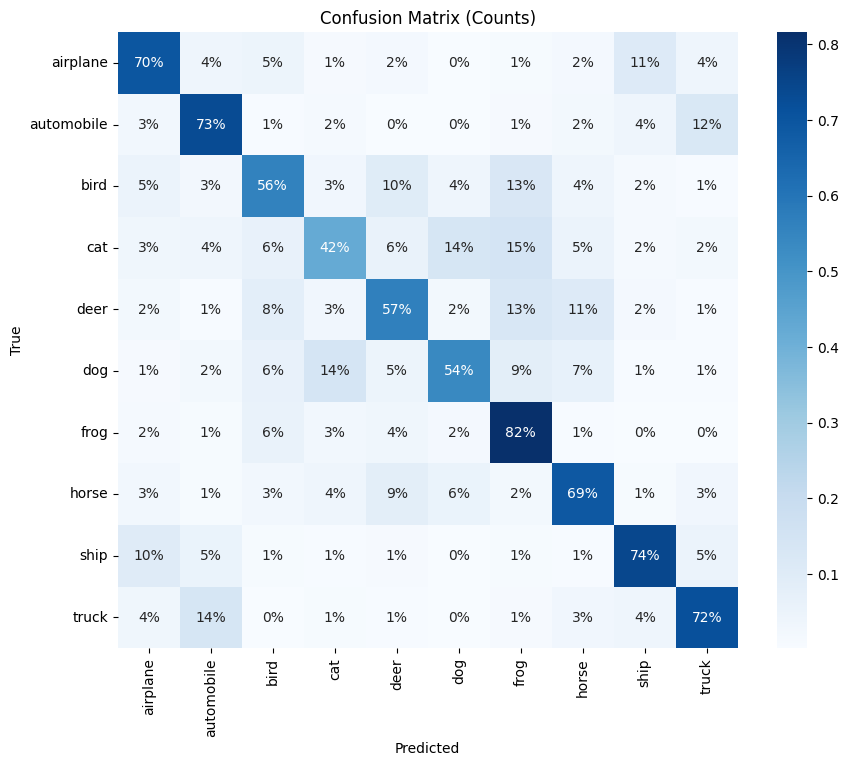

In [28]:
plot_confusion_matrix(model, test_images, test_labels)

In [29]:
# Classification Report
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_images), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step
              precision    recall  f1-score   support

    airplane       0.68      0.70      0.69      1000
  automobile       0.68      0.73      0.71      1000
        bird       0.60      0.56      0.58      1000
         cat       0.57      0.42      0.48      1000
        deer       0.60      0.57      0.58      1000
         dog       0.65      0.54      0.59      1000
        frog       0.59      0.82      0.69      1000
       horse       0.66      0.69      0.67      1000
        ship       0.74      0.74      0.74      1000
       truck       0.71      0.72      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.64     10000
weighted avg       0.65      0.65      0.64     10000



# Conclusion

This project demonstrates a complete deep learning pipeline for image classification on the CIFAR-10 dataset, with a focus on transfer learning using ResNet50.

Despite working with a reduced training subset (10,000 images), the model achieved strong results.

**PROJECT HIGHLIGHTS**

> **Preprocessing & Data Splitting:**
* Training set limited to 10,000 images, with 2,000 reserved for validation.
* 	One-hot encoding applied to labels.
* 	Image normalization using ResNet50 preprocessing.
* 	Robust data augmentation (rotation, flips, brightness, zoom, shift) to simulate variability and reduce overfitting.



> **Model Architecture:**
* Based on ResNet50 pretrained on ImageNet.
* Custom classification head with BatchNormalization and Dropout for regularization.
* Label smoothing during training to mitigate overconfidence.



> **Training Strategy:**
* Initial training with the base model frozen to learn the new head.
* 	Progressive fine-tuning in 4 phases:
* 	Gradually unfreezing deeper layers (5, 10, 15, 20).
* Using lower learning rates for deeper layers to prevent catastrophic forgetting.
* 	Employing cosine decay schedules for smooth LR reduction.
* 	Callbacks: EarlyStopping and ReduceLROnPlateau to avoid overfitting and plateauing.



> **Evaluation:**
* Best validation accuracy achieved: ~67%
* Test set accuracy: ~65% on 10,000 images.
* Confusion matrix highlighted strong classes (e.g. ship, frog, truck) and more challenging classes (e.g. cat, dog, bird).




**INSIGHTS & INTERPRETATIONS**



> * The progressive unfreezing approach allowed the model to adapt without damaging pretrained representations and improved accuracy.
* Label smoothing reduced overconfident misclassifications, promoting better generalization.
* The learning curves show clear benefits of staged fine-tuning, though gains plateau after ~15–20 layers unfrozen—suggesting diminishing returns.
* Certain classes remain difficult due to low resolution and intra-class similarity (cats/dogs/birds). This is consistent with CIFAR-10 challenges.
* Data augmentation was critical in mitigating overfitting with the small training subset.



**NEXT STEPS**



> * Use the full 50,000 training images to boost generalization.
* Experiment with alternative architectures (EfficientNet, Vision Transformers).
* Apply advanced augmentation (CutMix, RandAugment).
* Use advanced optimizers (Lookahead, AdaBelief).
* Investigate learning rate finders and 1cycle schedules.



**KEY LEARNINGS**



> This project serves as a practical demonstration of modern computer vision best practices:
* Data preparation and augmentation
* Transfer learning with a pretrained backbone
* Progressive layer unfreezing
* Learning rate scheduling
* Regularization via dropout and label smoothing
* Careful evaluation with metrics and visualizations


> Through this approach, we’ve built a well-structured, reusable pipeline for image classification on small datasets, showcasing the power and flexibility of transfer learning.





**CHALLENGES**

> Throughout this project, several practical challenges emerged that shaped both the modeling strategy and the final results:


> * **Small Training Set:**
With only 10,000 training images (a subset of CIFAR-10), the model was prone to overfitting and struggled to generalize to the test set. More data would likely yield significant gains.


> * **Low Resolution Images:**
ResNet50 is designed for larger inputs (224x224), while CIFAR-10 images are 32x32. Upsampling helps but cannot fully recover lost detail, limiting feature extraction quality.


> * **Confusing Classes:**
Classes like cat, dog, and bird are visually similar and small in frame. Even with augmentation and label smoothing, precision and recall for these classes remained lower.


> * **Long Training Times:**
Fine-tuning deeper layers (e.g. top 20) significantly increased training time per epoch. Iterating on hyperparameters required patience and careful planning.


> * **Learning Rate Tuning:**
Finding the right schedule was essential to avoid divergence or plateauing. The progressive unfreezing strategy demanded smaller and smaller learning rates.


> * **Library Compatibility:**
TensorFlow Addons had compatibility issues with newer TensorFlow versions, requiring fallback to native Keras optimizers (e.g. AdamW).


> These challenges highlight the real-world complexity of adapting cutting-edge deep learning models to constrained datasets. An invaluable learning experience for deploying computer vision pipelines thoughtfully.

**Key Takeaways**

✅ Even with limited data, transfer learning and careful fine-tuning can deliver solid results.

✅ Layer-wise unfreezing with tuned learning rates is effective for adapting large models.

✅ Visualization (accuracy/loss curves, confusion matrices) is essential for diagnosing model behavior and improving training strategy.

✅ Data augmentation remains vital when working with small or imbalanced datasets.